In [7]:
%load_ext autoreload
%autoreload 2

from wavesolve.waveguide import FiberBundleLantern
from wavesolve.fe_solver import get_eff_index, plot_vector_mode, plot_scalar_mode, solve_waveguide_vec, solve_waveguide
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from wavesolve.utils import create_distinct_colormap, plot_modes
import numpy as np
from tqdm.notebook import tqdm

import pickle
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


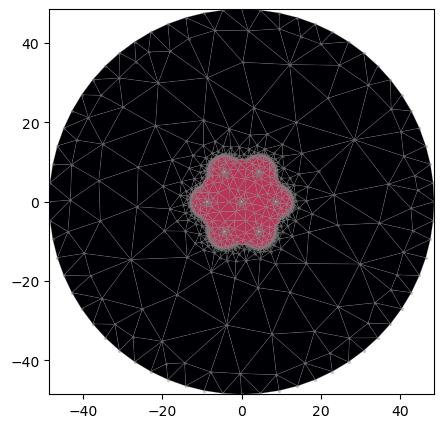

In [8]:
mm_core_radius=13
Bnd_PL = FiberBundleLantern(r_jack=700, r_fiber_clad=125/2, r_core=10.2/2, n_rings=1,
                            n_core=1.4521, n_clad=1.44692, n_jack=1.44692-5.e-3,
                            core_res=3, clad_res=64, jack_res=64,
                            r_target_mmcore_size=mm_core_radius,
                            ring_clad_factors={0: 2.5, 1: 1.0})

m = Bnd_PL.make_mesh(order=1,adaptive=True)

Bnd_PL.plot_mesh(m)

In [9]:
wl = 1.55
# w,v,n_modes = solve_waveguide(m,wl,Bnd_PL.assign_IOR(),plot=False,Nmax=100)
w,v,n_modes = solve_waveguide_vec(m, wl, Bnd_PL.assign_IOR(), plot=False, Nmax=100, sparse_solve_mode="pardiso", verbose=False)

print(f"{n_modes} vector modes were found.")

20 vector modes were found.


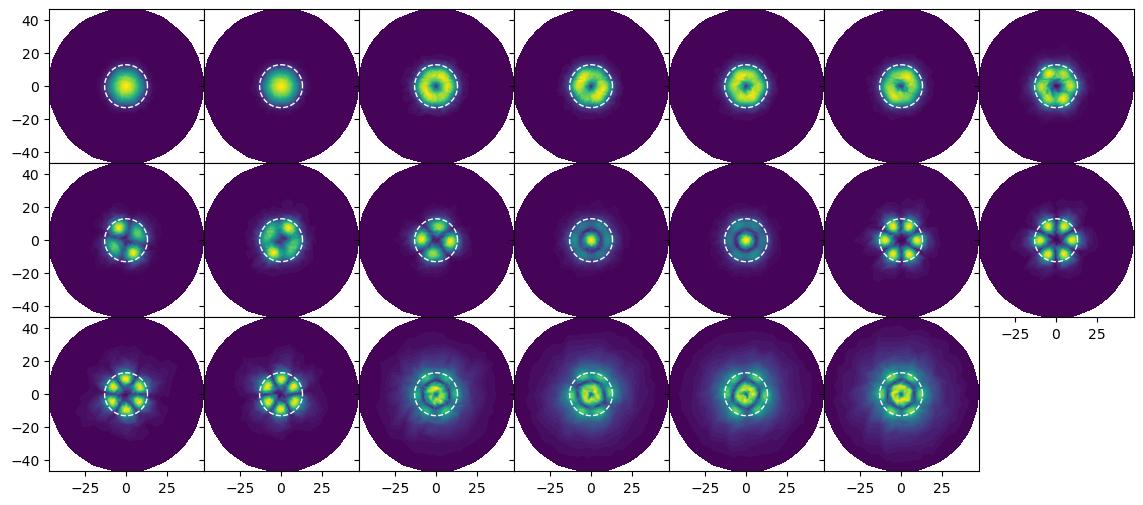

In [10]:
IOR_dict=Bnd_PL.assign_IOR()
plot_modes(w, v, m, wl, IOR_dict, target_radius=mm_core_radius,
               basefigsize=2, no_cols=7, circle_color='white',
               circle_linewidth=1, circle_linestyle='dashed',
               plot_vector=True)

In [ ]:
# Create directory for results
os.makedirs('simulation_results', exist_ok=True)

lambdaStart = 1.0
lambdaEnd = 1.8
rStart = 9
rEnd = 16
resolution = 14

wavelengths = np.linspace(lambdaStart, lambdaEnd, resolution)
radiuses = np.linspace(rStart, rEnd, resolution)

tileX = 0
tileY = 0
tiles = np.zeros((resolution, resolution))

for mm_core_radius in tqdm(radiuses,desc="Radius"):
    Bnd_PL = FiberBundleLantern(r_jack=700, r_fiber_clad=125/2, r_core=10.2/2, n_rings=1,
                                n_core=1.4521, n_clad=1.44692, n_jack=1.44692-5.e-3,
                                core_res=3, clad_res=64, jack_res=64,
                                r_target_mmcore_size=mm_core_radius,
                                ring_clad_factors={0: 2.5, 1: 1.0})

    m = Bnd_PL.make_mesh(order=1, adaptive=True)
    IOR_dict = Bnd_PL.assign_IOR()

    # Save mesh data for this radius
    mesh_filename = f'simulation_results/mesh_radius_{mm_core_radius:.3f}.pkl'
    with open(mesh_filename, 'wb') as f:
        pickle.dump({'mesh': m, 'IOR_dict': IOR_dict, 'Bnd_PL': Bnd_PL}, f)

    # Storage for this radius
    radius_results = {}

    for wavelength in tqdm(wavelengths, desc="Wavelengths", leave=False):
        w_PL, v_PL, N_PL = solve_waveguide_vec(m, wavelength, IOR_dict, plot=False,
                                              Nmax=80, sparse_solve_mode="pardiso", verbose=False)

        radius_results[wavelength] = {
            'w_PL': w_PL,
            'v_PL': v_PL,
            'N_PL': N_PL
        }

        tiles[tileX, tileY] = N_PL
        tileY += 1

    # Save results for this radius
    results_filename = f'simulation_results/results_radius_{mm_core_radius:.3f}.pkl'
    with open(results_filename, 'wb') as f:
        pickle.dump(radius_results, f)

    tileY = 0
    tileX += 1

# Save summary data
np.save('simulation_results/tiles_results.npy', tiles)
np.save('simulation_results/wavelengths.npy', wavelengths)
np.save('simulation_results/radiuses.npy', radiuses)

print("All data saved successfully!")

(18.0, 32.0)

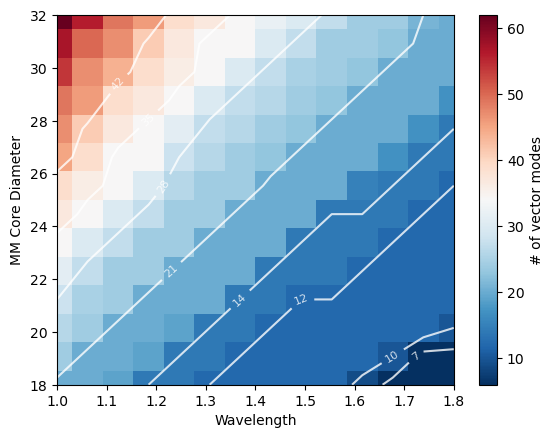

In [36]:
# Load summary data
tiles = np.load('simulation_results/tiles_results.npy')
wavelengths = np.load('simulation_results/wavelengths.npy')
radiuses = np.load('simulation_results/radiuses.npy')

contour_levels = np.unique(tiles.astype(int))


fig, ax = plt.subplots()
plt.xlabel("Wavelength")
plt.ylabel("MM Core Diameter")
im = ax.pcolormesh(wavelengths,2*radiuses, tiles, cmap='RdBu_r') #create_distinct_colormap(contour_levels.size))
# im = ax.pcolormesh(wavelengths,2*radiuses, tiles, cmap=create_distinct_colormap(contour_levels.size))
cbar = plt.colorbar(im, ax = ax)
cbar.set_label('# of vector modes')

# Overlay approximation as contour lines
contours = ax.contour(wavelengths, 2*radiuses, tiles, levels=[7,10, 12, 14, 21, 28, 35, 42],
                     colors='white', linewidths=1.5, alpha=0.8)
ax.clabel(contours, inline=True, fontsize=8, fmt='%d', colors='white')

ax.set_xlim(1, 1.8)
ax.set_ylim(np.min(2*radiuses), np.max(2*radiuses))

# labelypos=[np.min(2*radiuses),np.min(2*radiuses)+5]
# #Y
# plt.plot([1.02-.12/2, 1.02-.12/2],labelypos, color = 'w', linestyle = 'dashed')
# plt.plot([1.02+.12/2, 1.02+.12/2],labelypos, color = 'w', linestyle = 'dashed')
# plt.text(1.01,labelypos[0]+0.5,"Y", color = 'w', size = 15, fontstyle = 'italic', )
# #J
# plt.plot([1.22-.213/2, 1.22-.213/2],labelypos, color = 'w', linestyle = 'dashed')
# plt.plot([1.22+.213/2, 1.22+.213/2],labelypos, color = 'w', linestyle = 'dashed')
# plt.text(1.21,labelypos[0]+0.5,"J", color = 'w', size = 15, fontstyle = 'italic')
# #H
# plt.plot([1.63-.307/2, 1.63-.307/2],labelypos, color = 'w', linestyle = 'dashed')
# plt.plot([1.63+.307/2, 1.63+.307/2],labelypos, color = 'w', linestyle = 'dashed')
# plt.text(1.62,labelypos[0]+0.5,"H", color = 'w', size = 15, fontstyle = 'italic')


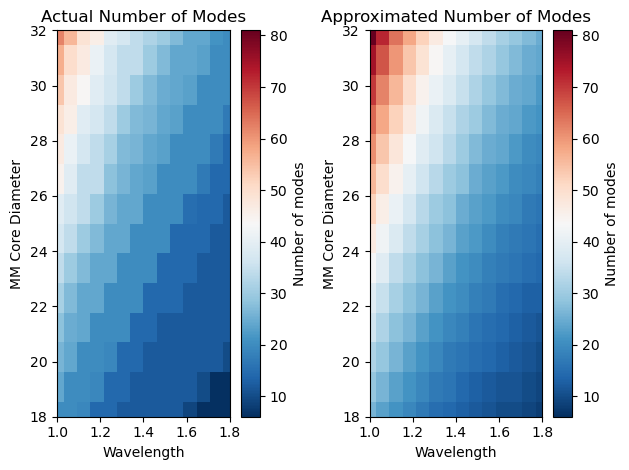

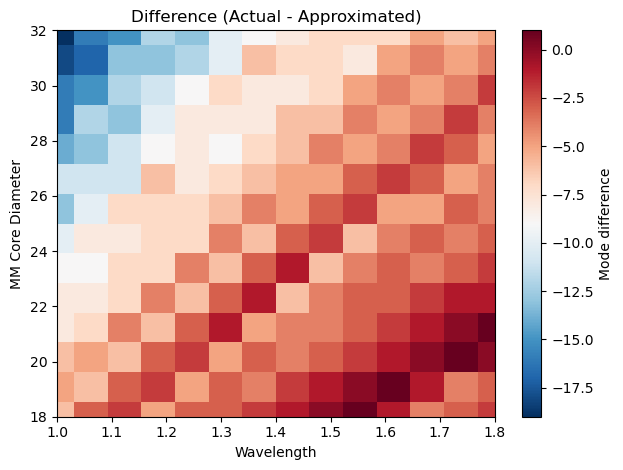

In [50]:
# Calculate the approximation array
tiles_approx = np.zeros_like(tiles)
for i, mm_core_radius in enumerate(radiuses):
    for j, wavelength in enumerate(wavelengths):
        tiles_approx[i, j] = np.ceil((2*np.pi*0.126*mm_core_radius/wavelength)**2/2)


# Alternative: Side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.4)  # Add space between subplots

# Calculate the range for the first two plots (actual and approximated modes)
mode_data = np.concatenate([tiles.flatten(), tiles_approx.flatten()])
vmin_modes, vmax_modes = np.min(mode_data), np.max(mode_data)

# Actual modes
im1 = ax1.pcolormesh(wavelengths, 2*radiuses, tiles, cmap='RdBu_r', vmin=vmin_modes, vmax=vmax_modes)
ax1.set_xlabel("Wavelength")
ax1.set_ylabel("MM Core Diameter")
ax1.set_title("Actual Number of Modes")
ax1.set_xlim(1, 1.8)
ax1.set_ylim(np.min(2*radiuses), np.max(2*radiuses))


# Approximated modes
im2 = ax2.pcolormesh(wavelengths, 2*radiuses, tiles_approx, cmap='RdBu_r', vmin=vmin_modes, vmax=vmax_modes)
ax2.set_xlabel("Wavelength")
ax2.set_ylabel("MM Core Diameter")
ax2.set_title("Approximated Number of Modes")
ax2.set_xlim(1, 1.8)
ax2.set_ylim(np.min(2*radiuses), np.max(2*radiuses))

# Create shared colorbar for first two plots
cbar_modes = plt.colorbar(im1, ax=ax1)
cbar_modes.set_label('Number of modes')
cbar_modes = plt.colorbar(im1, ax=ax2)
cbar_modes.set_label('Number of modes')

plt.tight_layout()
plt.show()

fig3, ax3 = plt.subplots(1, 1)
# Create a difference plot with its own color scale
difference = tiles - tiles_approx
im_diff = ax3.pcolormesh(wavelengths, 2*radiuses, difference, cmap='RdBu_r')
ax3.set_xlabel("Wavelength")
ax3.set_ylabel("MM Core Diameter")
ax3.set_title("Difference (Actual - Approximated)")
ax3.set_xlim(1, 1.8)
ax3.set_ylim(np.min(2*radiuses), np.max(2*radiuses))


# Create separate colorbar for the difference plot
cbar_diff = plt.colorbar(im_diff, ax=ax3)
cbar_diff.set_label('Mode difference')

plt.tight_layout()
plt.show()